# The Effects of Shrinkage Methods on Physician Prediction 
## PSTAT 126 – Linear Regression
### Sam Sheridan

## Shrinkage Methods

The overuse of predictors in a regression model may lead to a variety of problems. Prediction performance can slump and explanations can be difficult due to collinearity. Ridge and Lasso regressions alter the traditional ordinary least squares estimators by adding a penalty to a slope. Practically speaking models where a small change in a predictor leads to a larger change in the response are penalized. These shrinkage methods are a means to improve prediction accuracy and remove or diminish the effects of unnecessary predictors. 

In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [402]:
%matplotlib inline

In [403]:
CDI = pd.read_csv('CDI.csv')

In [404]:
CDI = CDI.drop('Unnamed: 0', axis=1) #drop redundant column

In [405]:
CDI.head()

,County,State,LandArea,TotalPop,Pop18,Pop65,Physicians,Beds,Crimes,HSGrad,Bachelor,Poverty,Unemp,IncPerCap,PersonalInc,Region
0,Cook,IL,946,5105067,29.2,12.4,15153,21550,436936,73.4,22.8,11.1,7.2,21729,110928,2
1,Harris,TX,1729,2818199,31.3,7.1,7553,12449,253526,74.9,25.4,12.5,5.7,19517,55003,3
2,San_Diego,CA,4205,2498016,33.5,10.9,5905,6179,173821,81.9,25.3,8.1,6.1,19588,48931,4
3,Orange,CA,790,2410556,32.6,9.2,6062,6369,144524,81.2,27.8,5.2,4.8,24400,58818,4
4,Kings,NY,71,2300664,28.3,12.4,4861,8942,680966,63.7,16.6,19.5,9.5,16803,38658,1


In [406]:
CDI['County'] = CDI['County'].astype('category')
CDI['State'] = CDI['State'].astype('category')
CDI['Region'] = CDI['Region'].astype('category')
CDI['TotalPop'] = CDI['TotalPop'].apply(np.log) #scale to improve normality assumptions
CDI['Physicians'] = CDI['Physicians'].apply(np.log) #scale to improve normality assumptions

In [407]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Partial Least Squares Model
 
I've created the linear models from earlier in the project to compare the later models too. First, the data is split into the predictor and the response, then rows for the training and testing data are randomly selected. This provides a method to measure the model's performance using previously unseen data. 

Specifically, these models will be fitted. 

***Physicians ~ log(TotalPop) + LandArea + IncPerCap***

and

***Physicians ~ log(TotalPop) + Region***

In [408]:
#create dummy variables for the regions
dummies = pd.get_dummies(CDI['Region'], prefix="Region")
CDI = pd.concat([CDI, dummies], axis = 1)

In [409]:
X_lm1 = CDI[['TotalPop', 'IncPerCap', 'LandArea']]
X_lm2 = CDI[['TotalPop', 'Region_1', 'Region_2', 'Region_3', 'Region_4']]
y_lm = CDI['Physicians']

The data is split into training and testing samples to later check prediction accuracy 

In [410]:
#partition training and testing data
X_train_lm1, X_test_lm1, y_train_lm1, y_test_lm1 = train_test_split(X_lm1, y_lm, test_size=0.33, random_state=47)
X_train_lm2, X_test_lm2, y_train_lm2, y_test_lm2 = train_test_split(X_lm2, y_lm, test_size=0.33, random_state=47)

## Ordinary Least Squares Model 1

In [411]:
#fit the first linear model
lm1 = linear_model.LinearRegression(normalize=True) #normalized for better comparison with later models
lm1.fit(X_train_lm1, y_train_lm1)
r_square_lm1 = lm1.score(X_test_lm1, y_test_lm1)
lm1_MSE = mean_squared_error(y_test_lm1, lm1.predict(X_test_lm1))
print("The Mean Squared Error for the first general linear model is %.2f" % lm1_MSE)
print("The R^2 value for the test data applied to the first linear model is %2f" % r_square_lm1)

The Mean Squared Error for the first general linear model is 0.20
The R^2 value for the test data applied to the first linear model is 0.848154


## Ordinary least Squares Model 2

In [412]:
#fit the second linear model 
lm2 = linear_model.LinearRegression(normalize=True) #normalized for better comparison with later models
lm2.fit(X_train_lm2, y_train_lm2)
r_square_lm2 = lm2.score(X_test_lm2, y_test_lm2)
lm2_MSE = mean_squared_error(y_test_lm2, lm2.predict(X_test_lm2))
print("The Mean Squared Error for the second general linear model is %.2f" % lm2_MSE)
print("The R^2 value for the test data applied to the second linear model is %2f" % r_square_lm2)

The Mean Squared Error for the second general linear model is 0.22
The R^2 value for the test data applied to the second linear model is 0.833498


## Full Least Squares Model 

In [413]:
X = CDI.drop(['Physicians', 'County', 'State', 'Region'], axis=1)
y = CDI['Physicians']

In [414]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 47)

In [415]:
lm_full = linear_model.LinearRegression(normalize=True)
lm_full.fit(X_train, y_train)
print("The Mean Squared Error for the least squares model with all the predictors is %.3f" % mean_squared_error(y_test, lm_full.predict(X_test)))
print("The R^2 for new data applied to the least squares model with all the predictors is %.3f" % lm_full.score(X_test, y_test))

The Mean Squared Error for the least squares model with all the predictors is 0.109
The R^2 for new data applied to the least squares model with all the predictors is 0.919


## Ridge Regression 

The ridge regression estimate chooses $\beta$ to minimize $(y - X\beta)^{T}(y - X\beta) + \lambda\sum_j\beta_j^{2}$

The estimated $\beta$'s are given by $\hat{\beta} = (X^{T}X + \lambda I)^{-1}X^{T}y$

Ridge regression assumes that the regression coefficients should not be large — this is a valid assumption when many predictors are believed to have a similar effect on the response. Ridge regression provides biased estimators for the coefficients, however, it may lead to a decrease in variance and can thus lower mean square error. This is a classic example of bias-variance tradeoff.


The function **RidgeCV** fits a Ridge Regression model and chooses a penalty parameter from a range of values by comparing the fitted models of the various parameters through cross-validation; it chooses the model with the lower mean squared error. A range of values from 0.001 to 1 incrementing by 0.01 are tested. Due to the relatively small size of the dataset, tuning the hyperparameter from a large range of values through cross-validation is feasible. 

In [416]:
ridge = linear_model.RidgeCV(normalize = True, alphas = np.arange(0.0001, 1, .001))
ridge.fit(X_train, y_train)
ridge_R = ridge.score(X_test, y_test)
ridge_MSE = mean_squared_error(y_test, ridge.predict(X_test))

In [417]:
print("The Mean Squared Error for the ridge model is %.2f" % ridge_MSE)
print("The R^2 value for new data applied to the ridge model is %.3f" % ridge_R)
print("The penalty coefficient is %.4f" % ridge.alpha_)

The Mean Squared Error for the ridge model is 0.11
The R^2 value for new data applied to the ridge model is 0.917
The penalty coefficient is 0.0091


In [418]:
print(ridge.coef_)

[-3.93804709e-05  1.12084873e+00  2.30279548e-02  3.51210479e-02
  1.80106998e-04 -1.50671092e-06  1.94039926e-03  1.94408896e-02
  5.31492438e-02 -5.88849677e-02  5.19598510e-05 -2.75550390e-05
  8.06081171e-02 -8.05966328e-02 -7.38139237e-02  1.18100840e-01]


The ridge regression has greatly reduced the impact of many predictors, however it cannot fully removed any of them. 

# Lasso Regression 

Lasso regression chooses $\hat{\beta}$ to minimize $(y-X\beta)^{T}(y-X\beta)$  subject to $\Sigma_{j=1}^{p}|\beta_j|\leq t$. This penalty may go to zero, removing predictors from the model and in effect grabbing the predictors you want with a metaphorical "lasso". Lasso regression is most applicable when the model is believed to be sparse; the response can be explained by a small number of predictors with the rest having no effect. The function **LassoCV** fits a lasso regression and chooses the optimal hyperparameter through cross-validation. 

In [419]:
lasso = linear_model.LassoCV(normalize=True, alphas=np.arange(.001, 1, .001))
lasso.fit(X_train, y_train)
lasso_R = lasso.score(X_test, y_test)
lasso_MSE = mean_squared_error(y_test, lasso.predict(X_test))

In [420]:
print("The Mean Squared Error for the lasso model is %.2f" % lasso_MSE)
print("The R^2 value for new data applied to the lasso model %.3f" % lasso_R)
print("The penalty coefficient is %.4f" % lasso.alpha_)

The Mean Squared Error for the lasso model is 0.12
The R^2 value for new data applied to the lasso model 0.914
The penalty coefficient is 0.0010


In [421]:
print(lasso.coef_)

[-1.53736237e-05  1.08113531e+00  1.37558789e-02  2.60680150e-02
  1.15736794e-04 -7.73859365e-07  0.00000000e+00  2.27414049e-02
  4.46093844e-02 -4.58720172e-02  3.95774348e-05 -1.34359256e-05
  9.06801643e-02 -7.95240530e-03 -0.00000000e+00  3.10653967e-02]


The lasso regression has not only reduced the impact of many predictors but has also set some $\beta$'s to zero fully removing predictors from the model. 

## Simplicity - Accuracy Tradeoff

### accuracy can be given up for a lower dimensional model

In [422]:
predictors_dropped = []
a = np.arange(0.001, 0.1, 0.001)
accuracy = []

In [423]:
for i in range(len(a)):
    l = linear_model.Lasso(normalize=True, alpha=a[i])
    l.fit(X_train, y_train)
    accuracy.append(l.score(X_test, y_test))
    predictors_dropped.append(len(np.where(l.coef_ == 0)[0]))
    

[]

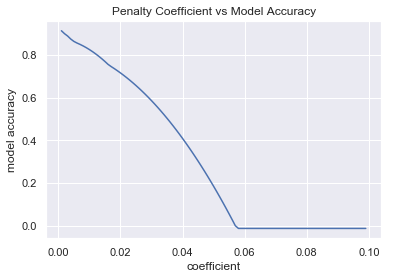

In [424]:
plt.plot(a, accuracy)
plt.title("Penalty Coefficient vs Model Accuracy")
plt.xlabel("coefficient")
plt.ylabel('model accuracy')
plt.plot()

The model is most accurate with the lowest given coefficient; if allowed the model would drop the penalty term and simply become the OLS model. 

[]

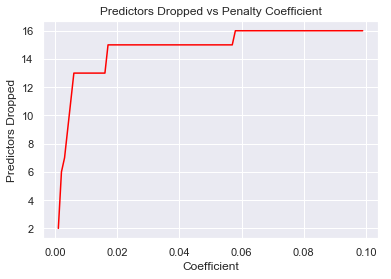

In [425]:
plt.plot(a, predictors_dropped, color='red')
plt.title("Predictors Dropped vs Penalty Coefficient")
plt.xlabel('Coefficient')
plt.ylabel('Predictors Dropped')
plt.plot()

As the penalty coefficient increases the prediction accuracy decreases, but the number of predictors dropped increases. This simplifies the model.

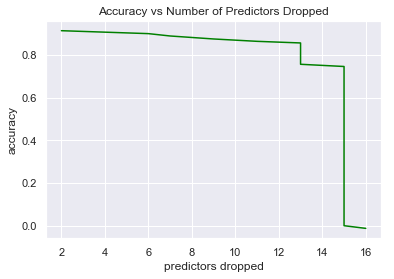

In [426]:
plt.plot(predictors_dropped, accuracy, color='green')
plt.title("Accuracy vs Number of Predictors Dropped")
plt.xlabel("predictors dropped")
plt.ylabel("accuracy")
plt.show()

A large number of predictors can be dropped without a significant decrease in prediction accuracy. A similarly accurate model can be produced with only 3 predictors.  

In [427]:
np.where(np.array(predictors_dropped) == 13)

(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),)

In [428]:
a[5]

0.006

In [429]:
small_model = linear_model.Lasso(normalize=True, alpha=0.006)
small_model.fit(X_train, y_train)

Lasso(alpha=0.006, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [430]:
small_model.score(X_test, y_test)

0.8567586557013054

In [443]:
print(small_model.coef_)

[-0.00000000e+00  9.76357853e-01  0.00000000e+00  0.00000000e+00
  6.95739423e-05  0.00000000e+00 -0.00000000e+00  2.05564482e-02
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00]


In [431]:
p = np.where(small_model.coef_ != 0)[0]
for x in X.iloc[:, p].columns:
        print(x)

TotalPop
Beds
Bachelor


Lasso Regression shrunk the data set down to TotalPop, Beds, and Bachelor while still having a prediction score of 0.86.

## Comparing The Models

There doesn't seem to be a significant difference in prediction accuracy between simply fitting a linear regression with all the predictors and fitting Lasso and Ridge models. Even though the lasso regression essentially has the same accuracy as the OLS full model, the lasso regression has removed many of the predictors, simplifying the model. The lasso regression also out-performed the smaller OLS models from the initial project using the same number of predictors. The parameters of the lasso model can be adjusted to give a smaller model, without a large tradeoff in accuracy making it very useful for removing unnecessary predictors 

The use of lasso regression in non-sparse models can sometimes prove unnecessary for prediction while still providing the benefit of dimensionality reduction. Furthermore while OLS models are generally more interpretable, the regularized regressions are often much better for prediction as they prevent overfitting. 

# Sparse Model example 

To show the benefits of a lasso model the training data will be sampled to create sparse training data. There are 425 rows and 16 columns, so around 20 rows of the data will be used to train the OLS and a lasso model. In order to train the OLS model for comparison, there must be more than 16 rows; however, the lasso model will still work on an extremely sparse subset of the data with under 16 rows. 

In [433]:
lasso_R = []
ols_R = []
lasso_mse = []
ols_mse = []

In [434]:
for i in range(100):
    X_train_sparse, X_test_sparse, y_train_sparse, y_test_sparse = train_test_split(X, y, test_size = 0.95, random_state = i)
    sparse_lasso = linear_model.LassoCV(normalize=True, alphas=np.arange(0.01, 1, .01))
    sparse_lasso.fit(X_train_sparse, y_train_sparse)
    lasso_R.append(sparse_lasso.score(X_test_sparse, y_test_sparse))
    lasso_mse.append(mean_squared_error(y_test_sparse, sparse_lasso.predict(X_test_sparse)))
    
    sparse_ols = linear_model.LinearRegression(normalize=True)
    sparse_ols.fit(X_train_sparse, y_train_sparse)
    ols_R.append(sparse_ols.score(X_test_sparse, y_test_sparse))
    ols_mse.append(mean_squared_error(y_test_sparse, sparse_ols.predict(X_test_sparse)))
    
    

In [435]:
print("The average lasso model's R^2 is %.3f" % np.mean(lasso_R))
print("The average lasso model's MSE is %.3f" % np.mean(lasso_mse))
print("The average OLS model's R^2 is %.3f" % np.mean(ols_R))
print("The average OLS model's MSE is %.3f" % np.mean(ols_mse))

The average lasso model's R^2 is 0.546
The average lasso model's MSE is 0.562
The average OLS model's R^2 is -0.895
The average OLS model's MSE is 2.354


In [436]:
print(sparse_lasso.coef_)

[ 0.00000000e+00  6.49437427e-01 -0.00000000e+00  5.09496341e-02
  2.87940427e-04  6.57320612e-06 -0.00000000e+00  3.23049395e-02
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  5.32001075e-06
 -0.00000000e+00 -1.42536226e-02  0.00000000e+00  4.01961405e-02]


In [437]:
print(sparse_ols.coef_)

[-8.03273945e-05  4.91971007e-01  7.63912287e-03  1.02830600e-01
  6.00028235e-04 -9.46011705e-06 -3.70640850e-03  6.71276825e-02
 -9.41101126e-02  8.46726839e-02 -3.78814249e-05  1.08556001e-05
 -4.85551893e-01 -1.69867318e-01  3.66728364e-01  2.44984900e-01]


The lasso regression full removes many of the predictors, while the OLS regression does not. 

## The Lasso model performs far better than OLS on sparse data sets
### This is shown in the following histograms

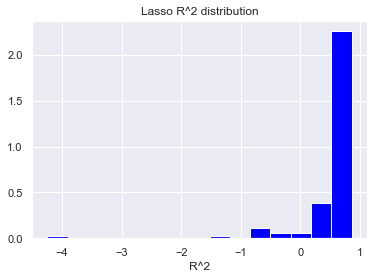

In [438]:
sns.set()
plt.hist(lasso_R, color='blue', density=True, bins = 15)
plt.title('Lasso R^2 distribution')
plt.xlabel('R^2')
plt.show()

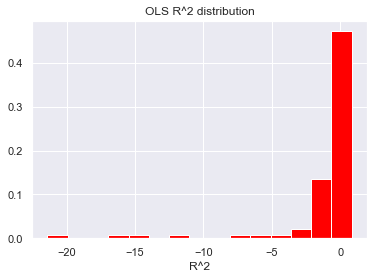

In [439]:
plt.hist(ols_R, color='red', density=True, bins=15)
plt.title('OLS R^2 distribution')
plt.xlabel('R^2')
plt.show()

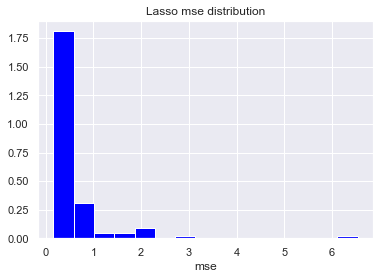

In [440]:
plt.hist(lasso_mse, color='blue', density=True, bins=15)
plt.title('Lasso mse distribution')
plt.xlabel('mse')
plt.show()

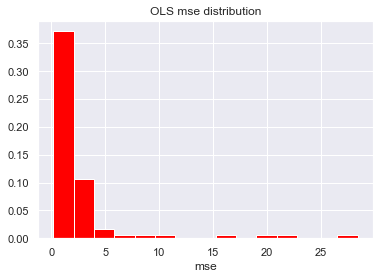

In [441]:
plt.hist(ols_mse, color='red', density=True, bins=15)
plt.title('OLS mse distribution')
plt.xlabel('mse')
plt.show()